In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from numba import cuda
import numba
import time
import multiprocessing as mp
import matplotlib.font_manager as font_manager
import sys
from tqdm import tqdm
import scipy.io as scio

In [73]:
@jit(nopython = True)
def Degree_generate_homo(node_num, lamb, k_min, k_max, seeds = 10):
#     np.random.seed(seeds)
    degree = np.ones(node_num)
    for i in range(int(node_num)):
        while(True):
            random_degree = np.random.poisson(lamb)
            if((random_degree >= k_min) and (random_degree <= k_max)):
                break           
        degree[i] = int(random_degree)
    return degree

@jit(nopython = True)
def network_generate(K, degree, seeds = 10):
#     np.random.seed(seeds)
    n = degree.size
#     p_max = 2*sigma/K
    m = int(np.max(degree))
    index_matrix = np.zeros((n,m))
#     p = np.zeros((n,m))
    degree_clone = np.copy(degree)
    fail_report, fail_report_degree = [], []     ### to double check how many edges do the left nodes have
    for i in range (int(n)):
        temp = []   ### to record the neighbors of nodes
        flag_temp = 0
        while(degree[i]!=0):
            flag = 0
            while(True):
                ram_connect = np.random.randint(degree.size) # 
                flag = flag + 1
#                 print(i, flag, ram_connect, degree[ram_connect])
                if (flag > (1000*degree.size)):
#                     print(i, flag_temp, 'fail')
                    flag = 0
                    fail_report.append(i)
                    break
                if ((ram_connect!= i) and (degree[ram_connect]!= 0) and ((ram_connect not in temp))):
                    break
            if(flag != 0):
                temp.append(ram_connect) 
                flag_temp = flag_temp + 1
                index_matrix[i][int(degree_clone[i] - degree[i])] = ram_connect
                index_matrix[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = i
#                 p_value = np.random.random()*p_max # [0, 1] * pmax
#                 p_value = 1e-1
#                 p[i][int(degree_clone[i]-degree[i])] = p_value
#                 p[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = p_value
                degree[i] = degree[i] - 1
                degree[ram_connect] = degree[ram_connect] - 1
            else:
                break
    for j in range(len(fail_report)):
        fail_report_degree.append(degree[int(fail_report[j])])
#     print(fail_report_degree)
    return index_matrix

# # @jit(nopython = True)
# def sigma_check(p,degree):
#     sigma = np.zeros(p.shape[0])
#     for i in range(p.shape[0]):
#         sigma[i] = degree[i]*p[i].sum()
#     return sigma

In [16]:
###   external stimulus   ###
@jit(nopython = True)
def external(t_min, t_max, t, r):
    if t_min < t < t_max:
        return (1 - np.exp(-r))
    else:
        return 0
###   internal(neural) stimulus   ###
@jit(nopython = True)  
def internal(p, index_matrix, index, state_matrix, degree):
    # index here is the neuron at resting state 
    probability = 0
    for i in range (int(degree[index])) :
        if (state_matrix[int(index_matrix[index][i])] == 1): # find the excitable neibour neuron
            probability = 1 - (1 - p[index][i]) * (1 - probability)
    return probability

@jit(nopython = True)
def state_update(r, t, t_min, t_max, p, index_matrix, index,\
                 state_matrix, degree, state_number, temp, random_arr):
    probability = 1 - ((1-external(t_min, t_max, t, r))* \
                        (1 - internal(p, index_matrix, index, state_matrix, degree)))
    if random_arr[index] < probability:
        temp[index] = 1
            
###   determine the activity   ###
@jit(nopython = True)
def rho_determine(state_matrix):
    active = [i for i, v in enumerate(state_matrix) if v==1]
    return len(active)/state_matrix.size

###   determine the average activity   ###
@jit(nopython = True)
def F0_determine(rho, T_min = 0, T_max = 1000):
    return rho[T_min:T_max].sum()/rho[T_min:T_max].size

In [17]:
@jit(nopython = True)
def KC_model(degree, index_matrix, p, t_min, stimulas_t, stimulas_S, MC_times, state_number):
    
    ###   Initialization   ###
    rho = np.zeros(MC_times)
    N = degree.size
    state_matrix = np.random.randint(0, state_number, N)
    temp = np.copy(state_matrix)
    
    ###   Monte Carlo   ###
    for t in range(MC_times):
        
        ###   Update refractory state   ###
        temp[np.where(state_matrix == 0)[0]] -= 1 
        temp[np.where(state_matrix<(state_number-1))] += 1 
        temp[np.where(state_matrix==(state_number-1))] = 0 
        
        ###   Locate the excitable neurons   ###
        zeros = np.where(state_matrix == 0)[0]
        random_arr = np.random.random(N)
        for i in range((zeros.size)):
            state_update(stimulas_S, t, t_min, stimulas_t, p, index_matrix, \
                         zeros[i], state_matrix, degree, state_number, temp, random_arr)
        state_matrix = np.copy(temp)
        rho[t] = rho_determine(state_matrix)
    return rho

In [18]:
import sys
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def autocorr_range(ts, lag_range):
    ac_array = []
    for lag in lag_range:
        ac_array.append(pd.Series.autocorr(pd.Series(ts), lag))
    return ac_array

def decay_func(x, a, tau, b):
    return a * np.exp(-(x/tau)) + b

def decay(data, lag_max):
    xvar = list(range(lag_max))
    
    popt, pcov = curve_fit(decay_func, xvar, autocorr_range(pd.Series(data), xvar))
    return popt # Return the decay constant

In [55]:
def init_network(K):
    N = 10**5
    # K = 10
    k_min = 2
    k_max = N - 1
    # sigma = 1
#     p_value = 1e-1

    degree = Degree_generate_homo(N, K, k_min, k_max)
    # print(np.max(degree))
    # print(np.random.randint(degree.size))
    # plt.plot(degree)
    degree_clone = degree.copy()
    network_connection = network_generate(K, degree_clone, 10)

#     ## propagation matrix 
#     network_p = np.copy(network_connection)
#     network_p[np.where(network_p != 0.0)] = p_value

    ## degree 
    network_index = np.copy(network_connection)
    network_index[np.where(network_index)] = 1
    network_degree = np.sum(network_index,axis = 1)
    return network_connection,network_degree

In [45]:
traget_sigma

array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
       1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65,
       1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95])

In [59]:
traget_sigma = np.arange(0.6,2,0.05)

k = 10
while k<22:
    N = 10**5 
    P = traget_sigma/k
    
    rho2 = []
    sigmas2 = []
    taus2 = []
    F02 = []

    times = 1000
    r = 1/N
    n = 10
    t_test = np.arange(times)
    network_connection,network_degree = init_network(k)
    print('********************************')
    print('Generated network with avaerage degree :%d'%(k))
    print('********************************')
        
    for p in P:
        
        network_p = np.copy(network_connection)
        network_p[np.where(network_p != 0.0)] = p
        
        network_connection_clone = np.copy(network_connection)
        network_degree_clone = np.copy(network_degree)
        network_p_clone = np.copy(network_p)

        print('==> ==> ==> sigma: %f'%round(network_degree_clone.sum()/N*p,2))

        rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times, r, times, n)
        rho2.append(rho_test)
        tau2 = decay(rho_test,25)
        taus2.append(tau2[1])
        sigmas2.append(round(network_degree_clone.sum()/N*p,2))
        F02.append(F0_determine(rho_test))

    scio.savemat(f'Aging_network/Timeseries_{k}_0402.mat',{'sigmas':sigmas2,'rho':rho2,'intf':taus2,'F0':F02})
    k = k+2

********************************
Generated network with avaerage degree :10
********************************
==> ==> ==> sigma: 0.600000
==> ==> ==> sigma: 0.650000
==> ==> ==> sigma: 0.700000
==> ==> ==> sigma: 0.750000
==> ==> ==> sigma: 0.800000
==> ==> ==> sigma: 0.850000
==> ==> ==> sigma: 0.900000
==> ==> ==> sigma: 0.950000
==> ==> ==> sigma: 1.000000
==> ==> ==> sigma: 1.050000
==> ==> ==> sigma: 1.100000
==> ==> ==> sigma: 1.150000
==> ==> ==> sigma: 1.200000
==> ==> ==> sigma: 1.250000
==> ==> ==> sigma: 1.300000
==> ==> ==> sigma: 1.350000
==> ==> ==> sigma: 1.400000
==> ==> ==> sigma: 1.450000
==> ==> ==> sigma: 1.500000
==> ==> ==> sigma: 1.550000
==> ==> ==> sigma: 1.600000
==> ==> ==> sigma: 1.650000
==> ==> ==> sigma: 1.700000
==> ==> ==> sigma: 1.750000
==> ==> ==> sigma: 1.800000
==> ==> ==> sigma: 1.850000
==> ==> ==> sigma: 1.900000
==> ==> ==> sigma: 1.950000
********************************
Generated network with avaerage degree :12
*******************************

In [47]:
F0

array([[3.269000e-05, 3.659000e-05, 4.177000e-05, 4.854000e-05,
        5.618000e-05, 7.644000e-05, 1.091700e-04, 2.159000e-04,
        9.882100e-04, 4.628220e-03, 8.977330e-03, 1.315026e-02,
        1.695734e-02, 2.051505e-02, 2.374762e-02, 2.676416e-02,
        2.966294e-02, 3.233985e-02, 3.475318e-02, 3.707850e-02,
        3.916606e-02, 4.120211e-02, 4.274446e-02, 4.379481e-02,
        4.462653e-02, 4.548168e-02, 4.631767e-02, 4.704046e-02]])

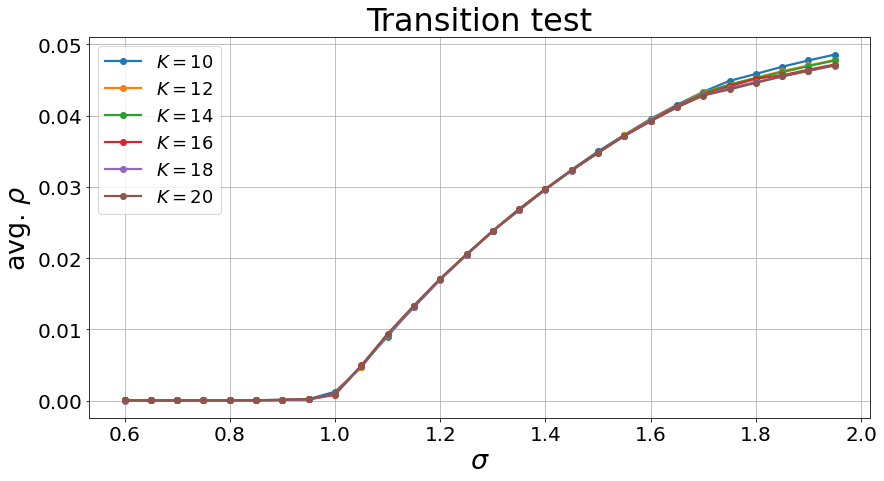

In [60]:
fig, ax = plt.subplots(figsize=(14, 7))
k = 10
while k<22:
    timeseries = scio.loadmat(f'Aging_network/Timeseries_{k}_0402.mat')
    sigmas = timeseries['sigmas']
    rho = timeseries['rho']
    taus = timeseries['intf']
    F0 = timeseries['F0']  
    # print(p,F0)
    ax.plot(sigmas[0], F0[0],  linewidth = 2.2, linestyle='-', marker = 'o', label = '$ K = %d $'%(k))
    k = k+2

ax.set_xlabel('$\sigma$',fontsize=27)
ax.set_ylabel('avg. $\\rho$ ',fontsize=27)
ax.set_title('Transition test',fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)
plt.grid()

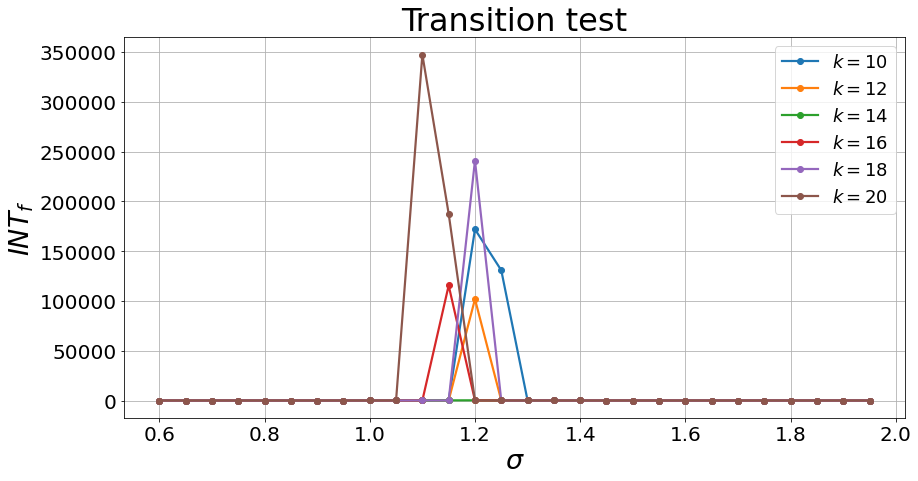

In [71]:
fig, ax = plt.subplots(figsize=(14, 7))
k = 10
while k<22:
    timeseries = scio.loadmat(f'Aging_network/Timeseries_{k}_0402.mat')
    sigmas = timeseries['sigmas']
    rho = timeseries['rho']
    taus = timeseries['intf']
    F0 = timeseries['F0']  
    # print(p,F0)
#     print(taus[0])
#     break
    ax.plot(sigmas[0], taus[0],  linewidth = 2.2, linestyle='-', marker = 'o', label = '$ k = %d $'%(k))
    k = k+2
#     break
ax.set_xlabel('$\sigma$',fontsize=27)
ax.set_ylabel('$INT_f$ ',fontsize=27)
ax.set_title('INT vs. $\sigma$  ',fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)
plt.grid()

In [76]:
traget_sigma = np.arange(0.6,2,0.05)

k = 10
while k<14:
    N = 10**5 
    P = traget_sigma/k
    
    rho2 = []
    sigmas2 = []
    taus2 = []
    F02 = []

    times = 1000
    r = 1/N
    n = 10
    t_test = np.arange(times)
    network_connection,network_degree = init_network(k)
    print('********************************')
    print('Generated network with avaerage degree :%d'%(k))
    print('********************************')
    print(network_connection)
#     for p in P:
        
#         network_p = np.copy(network_connection)
#         network_p[np.where(network_p != 0.0)] = p
        
#         network_connection_clone = np.copy(network_connection)
#         network_degree_clone = np.copy(network_degree)
#         network_p_clone = np.copy(network_p)

#         print('==> ==> ==> sigma: %f'%round(network_degree_clone.sum()/N*p,2))

#         rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times, r, times, n)
#         rho2.append(rho_test)
#         tau2 = decay(rho_test,25)
#         taus2.append(tau2[1])
#         sigmas2.append(round(network_degree_clone.sum()/N*p,2))
#         F02.append(F0_determine(rho_test))

#     scio.savemat(f'Aging_network/rangdom_Timeseries_{k}_0402.mat',{'sigmas':sigmas2,'rho':rho2,'intf':taus2,'F0':F02})
    k = k+2

********************************
Generated network with avaerage degree :10
********************************
[[15016. 11497. 59285. ...     0.     0.     0.]
 [87745. 53968. 95278. ...     0.     0.     0.]
 [46747. 82709. 81401. ...     0.     0.     0.]
 ...
 [ 8515. 17033. 17050. ...     0.     0.     0.]
 [ 4870. 11235. 13310. ...     0.     0.     0.]
 [ 8655. 13011. 38089. ...     0.     0.     0.]]
********************************
Generated network with avaerage degree :12
********************************
[[83556. 22907. 42673. ...     0.     0.     0.]
 [58452. 19135. 19060. ...     0.     0.     0.]
 [40279. 99030. 44477. ...     0.     0.     0.]
 ...
 [10727. 23127. 27412. ...     0.     0.     0.]
 [53637. 69214. 76305. ...     0.     0.     0.]
 [ 5407.  9445. 18371. ...     0.     0.     0.]]


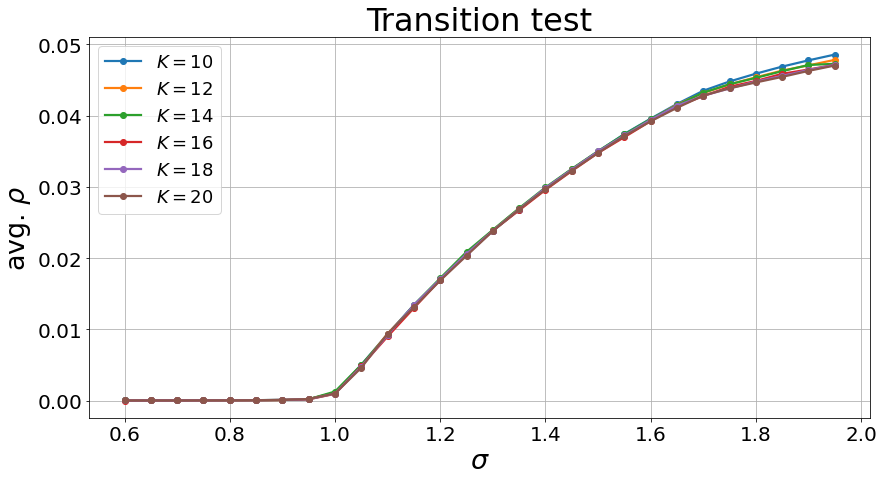

In [75]:
fig, ax = plt.subplots(figsize=(14, 7))
k = 10
while k<22:
    timeseries = scio.loadmat(f'Aging_network/rangdom_Timeseries_{k}_0402.mat')
    sigmas = timeseries['sigmas']
    rho = timeseries['rho']
    taus = timeseries['intf']
    F0 = timeseries['F0']  
    # print(p,F0)
    ax.plot(sigmas[0], F0[0],  linewidth = 2.2, linestyle='-', marker = 'o', label = '$ K = %d $'%(k))
    k = k+2

ax.set_xlabel('$\sigma$',fontsize=27)
ax.set_ylabel('avg. $\\rho$ ',fontsize=27)
ax.set_title('Transition test',fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)
plt.grid()

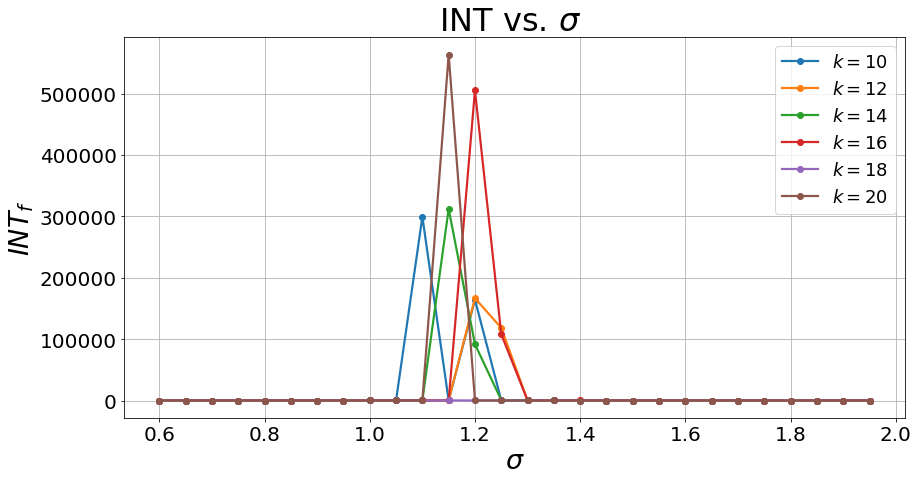

In [78]:
fig, ax = plt.subplots(figsize=(14, 7))
k = 10
while k<22:
    timeseries = scio.loadmat(f'Aging_network/rangdom_Timeseries_{k}_0402.mat')
    sigmas = timeseries['sigmas']
    rho = timeseries['rho']
    taus = timeseries['intf']
    F0 = timeseries['F0']  
    # print(p,F0)
#     print(taus[0])
#     break
    ax.plot(sigmas[0], taus[0],  linewidth = 2.2, linestyle='-', marker = 'o', label = '$ k = %d $'%(k))
    k = k+2
#     break
ax.set_xlabel('$\sigma$',fontsize=27)
ax.set_ylabel('$INT_f$ ',fontsize=27)
ax.set_title('INT vs. $\sigma$  ',fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)
plt.grid()

In [ ]:
# fig, ax = plt.subplots(figsize=(14, 7))
# k = 10
# while k<22:
#     timeseries = scio.loadmat(f'Aging_network/rangdom_Timeseries_{k}_0402.mat')
#     sigmas = timeseries['sigmas']
#     rho = timeseries['rho']
#     taus = timeseries['intf']
#     F0 = timeseries['F0']  
#     # print(p,F0)
#     ax.plot(sigmas[0], taus[0],  linewidth = 2.2, linestyle='-', marker = 'o', label = '$ K = %d $'%(k))
#     k = k+2

# ax.set_xlabel('$\sigma$',fontsize=27)
# ax.set_ylabel('avg. $\\rho$ ',fontsize=27)
# ax.set_title('Transition test',fontsize=32)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# font_prop = font_manager.FontProperties(size=18)
# ax.legend(prop = font_prop)
# plt.grid()

(28, 1000)
[0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25
 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95]
4
8
16
24
27


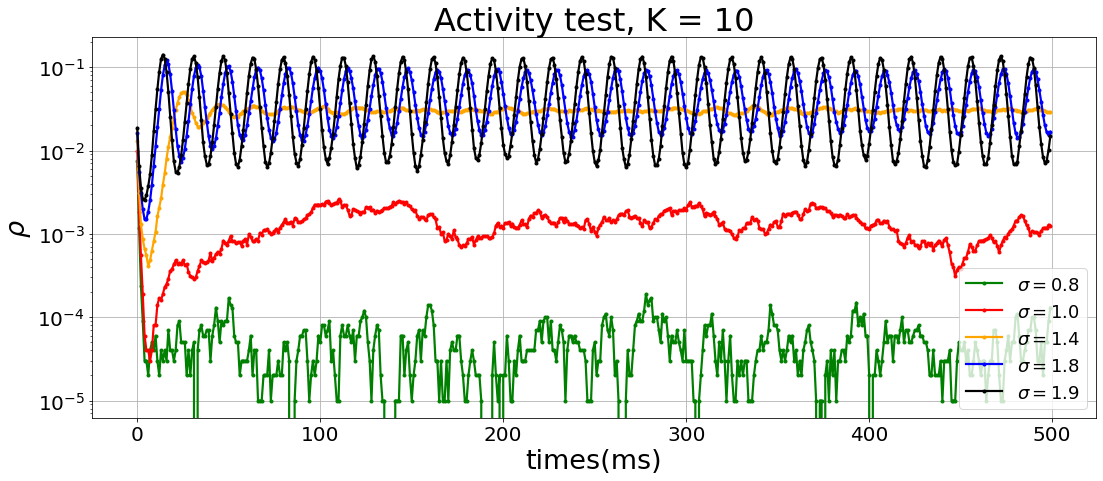

In [12]:
# fig, ax = plt.subplots(figsize=(14, 7))

k = 10
while k<22:
    timeseries = scio.loadmat(f'Aging_network/rangdom_Timeseries_{k}_0402.mat')
    sigmas = timeseries['sigmas'][0]
    rho = timeseries['rho']
    print(rho.shape)
    print(sigmas)
    targets = [0.8, 1.0, 1.4, 1.8, 1.95]
    fig, ax = plt.subplots(figsize=(18, 7))
    times = 1000
    t_test = np.arange(times)
    color = ['green', 'red', 'orange', 'blue','black']
    for n, i in enumerate(targets):
        ind = np.where(sigmas == i)[0][0]
        print(ind)
        # print(n//3)
        rho_t = rho[int(ind)]
        ax.plot(t_test[:500], rho_t[:500], marker = '.', color = color[n], linewidth = 2.2, linestyle='-',
                label = '$\sigma=%.1f$'%(i))
    break
#     taus = timeseries['intf']
#     F0 = timeseries['F0']  
#     # print(p,F0)
#     ax.plot(t_test[:500], rho_t[:500],  linewidth = 2.2, linestyle='-', marker = 'o', label = '$ K = %d $'%(k))
#     k = k+2


# targets = [0.8,1.0,1.4,1.8,2.0]
# fig, ax = plt.subplots(figsize=(18, 7))
# color = ['green', 'red', 'orange', 'blue','black']
# for n, i in enumerate(targets):
#     ind = np.where(sigmas == i)[0][0]
#     # print(n//3)
    
#     rho_t = rho[int(ind)]
#     ax.plot(t_test[:500], rho_t[:500], marker = '.', color = color[n], linewidth = 2.2, linestyle='-',
#             label = '$\sigma=%.1f$'%(i))

ax.set_xlabel('times(ms)',fontsize=27)
ax.set_ylabel('$\\rho$',fontsize=27)
ax.set_title('Activity test, K = 10',fontsize=32)
ax.set_yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)
plt.grid()
# print('Time cost:', time.time()-start_i)

In [3]:
@jit(nopython = True)
def convert_index_to_matrix(network):
    network_connection_m = np.zeros((network.shape[0],network.shape[0]))

    xys = np.where(network)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])]
    for i in xy:
#         print(i)
        a, b = i[0],i[1]
#         print(a,b)
        ij = network[int(a),int(b)]
        network_connection_m[int(a),int(ij)] = 1
        network_connection_m[int(ij),int(a)] = 1
    return network_connection_m

In [ ]:
network_connection_m = convert_index_to_matrix(network)
# network_connection_m = np.zeros((network.shape[0],network.shape[0]))
# print(network_connection_m.shape)
# xys = np.where(network)
#     # print(xys)
# xy = [i for i in zip(xys[0],xys[1])]
# for i in xy:
# #     print(i)
#     a, b = i[0],i[1]
# #     print(a,b)
#     ij = network[int(a),int(b)]
# #     print(ij)
#     print(int(a),int(ij))
#     break
#     network_connection_m[int(a),int(ij)] = 1
#     network_connection_m[int(ij),int(a)] = 1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# data = np.random.random((10,10))
plt.imshow(np.asarray(network_p))
# plt.imshow(np.random.random((50,50)))
plt.colorbar()
plt.show()